In [19]:
import numpy as np
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def create_feature_sets_and_labels(test_size = 0.3):

    # known patterns (5 features) output of [1] of positions [0,4]==1
    features = []
    features.append([[0, 0, 0, 0, 0], [0,1]])
    features.append([[0, 0, 0, 0, 1], [0,1]])
    features.append([[0, 0, 0, 1, 1], [0,1]])
    features.append([[0, 0, 1, 1, 1], [0,1]])
    features.append([[0, 1, 1, 1, 1], [0,1]])
    features.append([[1, 1, 1, 1, 0], [0,1]])
    features.append([[1, 1, 1, 0, 0], [0,1]])
    features.append([[1, 1, 0, 0, 0], [0,1]])
    features.append([[1, 0, 0, 0, 0], [0,1]])
    features.append([[1, 0, 0, 1, 0], [0,1]])
    features.append([[1, 0, 1, 1, 0], [0,1]])
    features.append([[1, 1, 0, 1, 0], [0,1]])
    features.append([[0, 1, 0, 1, 1], [0,1]])
    features.append([[0, 0, 1, 0, 1], [0,1]])
    features.append([[1, 0, 1, 1, 1], [1,0]])
    features.append([[1, 1, 0, 1, 1], [1,0]])
    features.append([[1, 0, 1, 0, 1], [1,0]])
    features.append([[1, 0, 0, 0, 1], [1,0]])
    features.append([[1, 1, 0, 0, 1], [1,0]])
    features.append([[1, 1, 1, 0, 1], [1,0]])
    features.append([[1, 1, 1, 1, 1], [1,0]])
    features.append([[1, 0, 0, 1, 1], [1,0]])

    # shuffle out features and turn into np.array
    random.shuffle(features)
    features = np.array(features)

    # split a portion of the features into tests
    testing_size = int(test_size*len(features))

    # create train and test lists
    train_x = list(features[:,0][:-testing_size])
    train_y = list(features[:,1][:-testing_size])
    test_x = list(features[:,0][-testing_size:])
    test_y = list(features[:,1][-testing_size:])

    return train_x, train_y, test_x, test_y

In [33]:
train_x, train_y, test_x, test_y = create_feature_sets_and_labels()

# hidden layers and their nodes
n_nodes_hl1 = 20
n_nodes_hl2 = 20

# classes in our output
n_classes = 2
# iterations and batch-size to build out model
hm_epochs = 1000
batch_size = 4
    
x = tf.placeholder('float')
y = tf.placeholder('float')

# random weights and bias for our layers
hidden_1_layer = {'f_fum':n_nodes_hl1,
                  'weight':tf.Variable(tf.random_normal([len(train_x[0]), n_nodes_hl1])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl1]))}

hidden_2_layer = {'f_fum':n_nodes_hl2,
                  'weight':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl2]))}

output_layer = {'f_fum':None,
                'weight':tf.Variable(tf.random_normal([n_nodes_hl2, n_classes])),
                'bias':tf.Variable(tf.random_normal([n_classes])),}


# our predictive model's definition
def neural_network_model(data):

    # hidden layer 1: (data * W) + b
    l1 = tf.add(tf.matmul(data,hidden_1_layer['weight']), hidden_1_layer['bias'])
    l1 = tf.sigmoid(l1)

    # hidden layer 2: (hidden_layer_1 * W) + b
    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weight']), hidden_2_layer['bias'])
    l2 = tf.sigmoid(l2)

    # output: (hidden_layer_2 * W) + b
    output = tf.matmul(l2,output_layer['weight']) + output_layer['bias']
    
    return output


# training our model
def train_neural_network(x):
    # use the model definition
    prediction = neural_network_model(x)

    # formula for cost (error)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )

    # optimize for cost using GradientDescent
    optimizer = tf.train.GradientDescentOptimizer(1).minimize(cost)

    # Tensorflow session
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter('log_ANN_graph', sess.graph)
        # initialize our variables
        sess.run(tf.global_variables_initializer())

        # loop through specified number of iterations
        for epoch in range(hm_epochs):
            epoch_loss = 0
            i=0
            # handle batch sized chunks of training data
            while i < len(train_x):
                start = i
                end = i+batch_size
                batch_x = np.array(train_x[start:end])
                batch_y = np.array(train_y[start:end])

                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
                epoch_loss += c
                i+=batch_size
                last_cost = c

            # print cost updates along the way
            if (epoch% (hm_epochs/5)) == 0:
                print('Epoch', epoch, 'completed out of',hm_epochs,'cost:', last_cost)
        
        # print accuracy of our model
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval({x:test_x, y:test_y}))

        output_weight = sess.run(output_layer['weight'])
        output_bias = sess.run(output_layer['bias'])
        
        # print predictions using our model
        for i,t in enumerate(test_x):
            print ('prediction for:', test_x[i])
            output = prediction.eval(feed_dict = {x: [test_x[i]]})
            # normalize the prediction values
            print(tf.sigmoid(output[0][0]).eval(), tf.sigmoid(output[0][1]).eval())
        
        return output_weight, output_bias
    
output_weight, output_bias = train_neural_network(x)

Epoch 0 completed out of 1000 cost: 4.12864
Epoch 200 completed out of 1000 cost: 0.000979323
Epoch 400 completed out of 1000 cost: 0.000433957
Epoch 600 completed out of 1000 cost: 0.000272617
Epoch 800 completed out of 1000 cost: 0.000196732
Accuracy: 1.0
prediction for: [1, 0, 1, 0, 1]
0.948319 0.0155814
prediction for: [1, 0, 1, 1, 0]
0.0233761 0.995126
prediction for: [1, 1, 0, 0, 0]
0.0320796 0.98737
prediction for: [1, 0, 0, 1, 0]
0.0239912 0.988221
prediction for: [0, 0, 0, 1, 1]
0.00961654 0.993522
prediction for: [0, 1, 1, 1, 1]
0.00917099 0.99366


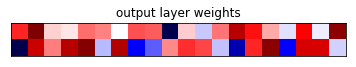

In [34]:
plt.title('output layer weights')
plt.imshow(output_weight.reshape([2, 20]), cmap=plt.get_cmap('seismic'))
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False) 
plt.show()

In [38]:
output_bias

array([-0.85731703, -0.77513015], dtype=float32)